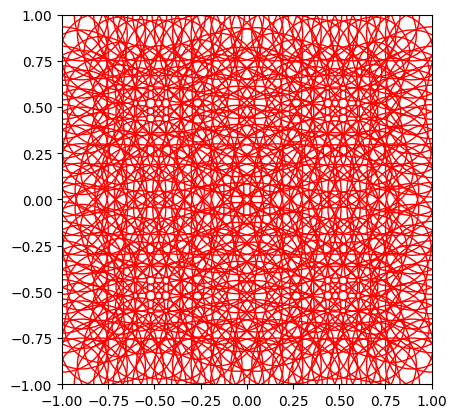

[0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.25       0.25       0.25
 0.25       0.25       0.25       0.24725169 0.24043683 0.23279848
 0.22746375 0.22630358 0.22969123 0.23650323 0.24416863 0.24928797
 0.24928797 0.24416863 0.23650323 0.22969123 0.22630358 0.22746375
 0.23279848 0.24043683 0.24725169 0.25       0.25       0.24043683
 0.21885228 0.19772226 0.18456688 0.1818599  0.18991429 0.20760577
 0.23031741 0.24747075 0.24747075 0.23031741 0.20760577 0.18991429
 0.1818599  0.18456688 0.19772226 0.21885228 0.24043683 0.25
 0.25       0.23279848 0.19772226 0.16765162 0.1507284  0.14739972
 0.15745458 0.18124326 0.21574784 0.24534171 0.24534171 0.21574784
 0.18124326 0.15745458 0.14739972 0.1507284  0.16765162 0.19772226
 0.23279848 0.25       0.25       0.22746375 0.18456688 0.1507284
 0.13275943 0.12931067 0.13981308 0.16570888 0.20612186 0.24379332
 0.24379332 0.206121

In [32]:
from collections import defaultdict
from dimod import SimulatedAnnealingSampler
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d

# 2D Function

def f(x, y):
    return np.sin(  np.pi * x)*np.sin( np.pi * y)

def f_second_norm(x, y):
    return -np.sin( np.pi * x)*np.sin( np.pi * y) # Only depends on x

def comp_radius(x, y, min_r, max_r):
    k1 = min_r / (max_r - min_r)
    k2 = max_r * min_r / (max_r - min_r)
    radius = k2 / (f_second_norm(x, y) ** 2 + k1)
    return radius

# Define 2D mesh points
num_points_x = 20
num_points_y = 20
x_tot = np.linspace(-1, 1, num_points_x)
y_tot = np.linspace(-1, 1, num_points_y)
X, Y = np.meshgrid(x_tot, y_tot)
points = np.column_stack([X.ravel(), Y.ravel()])

# Parameters
F = 200  # Max number of nodes
beta = 1  # Enforcing parameter for sparsity
alpha = 5  # Interference enforcing parameter
area_weight = 5  # Area enforcement
min_radius = 1 / 8
max_radius = 1 / 4

# Initialize QUBO matrix
Q = defaultdict(int)

# Compute radii for all points
radii = np.array([comp_radius(x, y, min_radius, max_radius) for x, y in points])

# Define the QUBO matrix
for i in range(len(points)):
    area = radii[i] ** 2 * np.pi
    Q[(i, i)] = -area_weight * area + beta * (1 - 2 * F)

    for j in range(i + 1, len(points)):
        dist = np.linalg.norm(points[i] - points[j])
        interference = max(0, radii[i] + radii[j] - dist)
        Q[(i, j)] = 2 * beta + alpha * interference**2 * np.pi

# Visualization
fig, ax = plt.subplots()
for j in range(len(points)):
    ax.add_patch(plt.Circle(points[j], radii[j], color='r', fill=False))

plt.gca().set_aspect('equal')
plt.xlim((-1, 1))
plt.ylim((-1, 1))
plt.show()

print(radii)


In [33]:
# Define the sampler that will be used to run the problem
#sampler = EmbeddingComposite(DWaveSampler())
# Instantiate the sampler
sampler = SimulatedAnnealingSampler()

# Run the problem on the sampler and print the results
sampleset = sampler.sample_qubo(Q,
                                 num_reads = 1)
#print(sampleset) #prints energy, number of occurencies and 
result = sampleset.first.sample #lowest energy sample

#print(first)
#for k in range(9):
    #print(result[k])


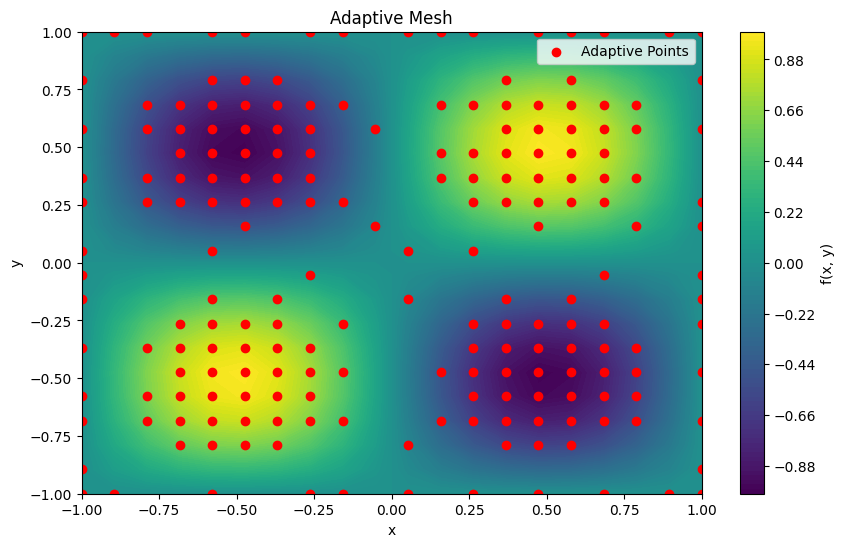

In [34]:
from mpl_toolkits.mplot3d import Axes3D
# Extract selected adaptive points
x_adapt = [points[k, 0] for k in range(len(points)) if result[k] == 1]
y_adapt = [points[k, 1] for k in range(len(points)) if result[k] == 1]
points_adapt = np.column_stack([np.array(x_adapt).ravel(), np.array(y_adapt).ravel()])
z_adapt = f(np.array(x_adapt), np.array(y_adapt))
X_a, Y_a = np.meshgrid(x_adapt, y_adapt)

# Initial uniform mesh
x_initial = np.linspace(-1, 1, 11)
y_initial = np.zeros_like(x_initial)
z_initial = f(x_initial, y_initial)

# 3D Surface Plot

plt.figure(figsize=(10, 6))
plt.contourf(X, Y, f(X, Y), cmap='viridis', levels=100)
plt.colorbar(label="f(x, y)")
plt.scatter(x_adapt, y_adapt, color='r', label="Adaptive Points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
#fig = plt.figure(figsize=(10, 6))
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X, Y, f(X, Y), cmap='viridis', alpha=0.6)
#ax.scatter(x_adapt, y_adapt, z_adapt, color='r', label="Adaptive Points")
#ax.set_xlabel("x")
#ax.set_ylabel("y")
#ax.set_zlabel("f(x, y)")
#ax.legend()
plt.title("Adaptive Mesh")
plt.show()


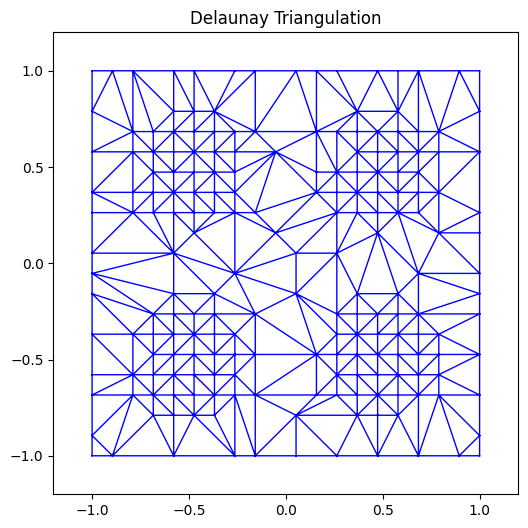

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay


# Perform Delaunay triangulation
tri = Delaunay(points_adapt)

# Plot the points and the triangulation
plt.figure(figsize=(6, 6))
plt.triplot(points_adapt[:, 0], points_adapt[:, 1], tri.simplices, color='blue', lw=1)  # Plot the triangulation edges
#plt.plot(points_adapt[:, 0], points_adapt[:, 1], 'ro')  # Plot the points
# Set axis limits to match the point range
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)


plt.title('Delaunay Triangulation')
plt.show()